# LeNet version of Fashiong MNIST

Let's use the very first (modern) NN [LeNet](https://en.wikipedia.org/wiki/LeNet) which we created.

In [36]:
device = "cuda"

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [34]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
!pip install -q duckduckgo_search
import imitools as I

Cloning into 'imitools'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 115 (delta 61), reused 33 (delta 15), pack-reused 0
Receiving objects: 100% (115/115), 4.45 MiB | 8.11 MiB/s, done.
Resolving deltas: 100% (61/61), done.


## Load Data

In [41]:
transform_pil=transforms.Compose([
  transforms.ToTensor(), # first, convert image to PyTorch tensor
])

In [42]:
ds_train = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)
ds_valid = datasets.FashionMNIST("~/data", train=True, download=True, transform=transform_pil)

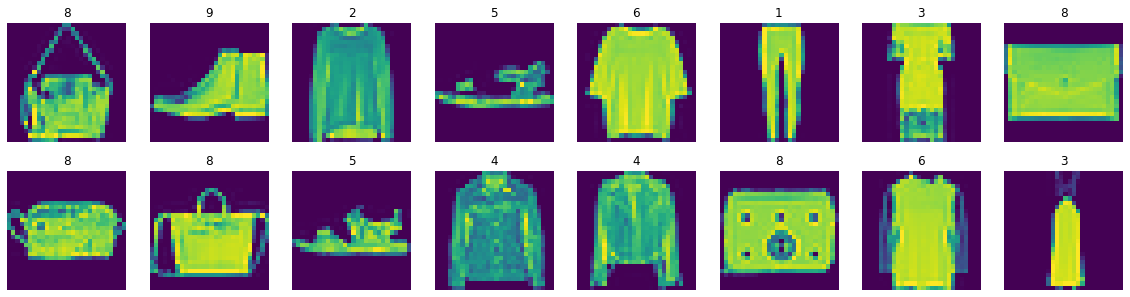

In [43]:
_dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=16)
sample_batch = next(iter(_dl))
I.wrap(*sample_batch).show(cols=8)

## Defining Lenet

In [19]:
test_images = sample_batch[0].to(device)
test_images.shape

torch.Size([16, 1, 28, 28])

In [44]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
        
    def forward(self, inputs):
        return self.net(inputs)
    
_net = LeNet()
_net(sample_batch[0]).shape

torch.Size([16, 10])

## Model & Training

In [89]:
def calc_accuracy(images, labels):
    batch_size = len(images)
    pred = model(images)
    pred = pred.detach()

    pred_labels = torch.argmax(pred, dim=-1)
    accuracy = (pred_labels == labels).sum() / batch_size * 100

    return accuracy

In [60]:
def train(epochs=1):
    loss_list = []
    valid_loss_list = []
    accuracy_list = []
    valid_accuracy_list = []

    lp = I.live_plot(2)
    i = 0

    for epoch in range(epochs):
        for batch in tqdm(dl_train):
            i += 1;
            images = batch[0].to(device)
            labels = batch[1].to(device)
            batch_size = len(images)

            optimizer.zero_grad()

            yhat = model(images)
            loss = F.cross_entropy(yhat, labels)

            loss.backward()

            with torch.no_grad():   
                optimizer.step()


        with torch.no_grad():
            _dl = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=64)
            sample = next(iter(_dl))
            train_images, train_lables = sample[0].to(device), sample[1].to(device)

            accuracy_list.append(calc_accuracy(train_images, train_lables).cpu().item())
            train_loss = F.cross_entropy(model(train_images), train_lables)
            loss_list.append(train_loss.item())

            _dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=64)
            sample = next(iter(_dl))
            valid_images, valid_lables = sample[0].to(device), sample[1].to(device)

            valid_accuracy_list.append(calc_accuracy(valid_images, valid_lables).cpu().item())
            valid_loss = F.cross_entropy(model(valid_images), valid_lables)
            valid_loss_list.append(valid_loss.item())

        lp.plot(0, loss_list, label="train loss")
        lp.plot(0, valid_loss_list, label="valid loss")
        lp.plot(1, accuracy_list, label="train accuracy")
        lp.plot(1, valid_accuracy_list, label="valid accuracy")
        lp.update()

    lp.close()

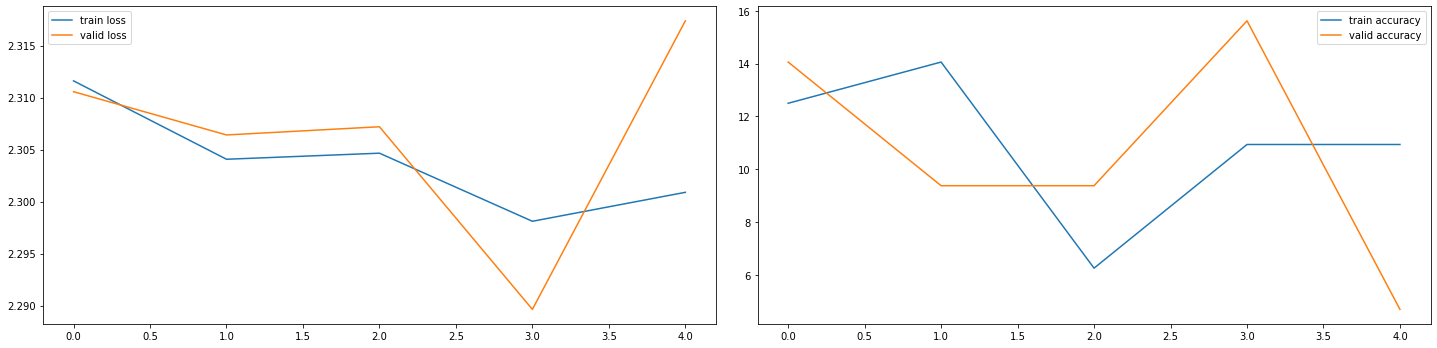

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

In [70]:
epochs = 10
bs = 16
lr = 0.1
wd = 0.0005

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = LeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [71]:
def calc_valid_accuracy():
    _dl = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=128)
    accuracy_list = []
    for batch in tqdm(_dl):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        with torch.no_grad():
            accuracy_list.append(calc_accuracy(images, labels))

    return torch.tensor(accuracy_list).mean().item()

calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

10.00355339050293

**Well. These are not training that well.**

The reason is weights are not initialized well. Here, we can apply some tricks like below.

## Weight Initialization

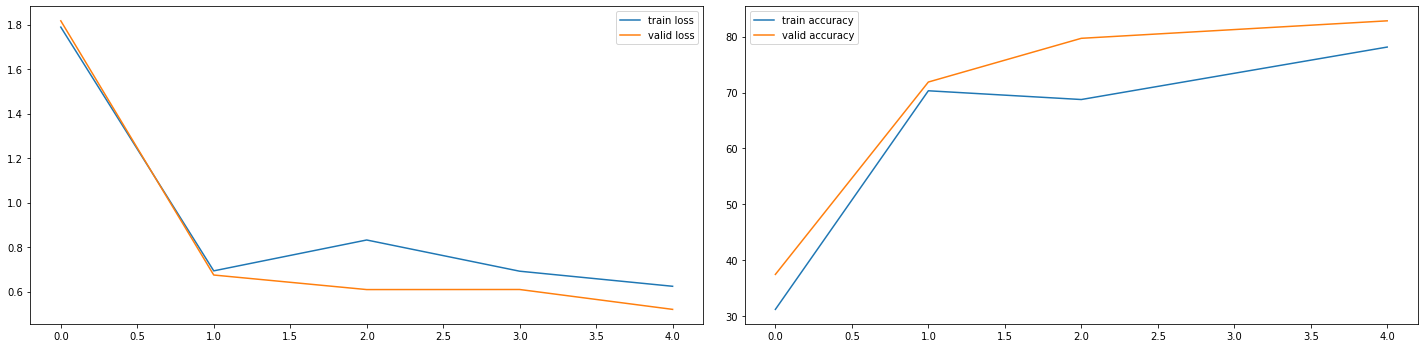

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

In [74]:
epochs = 10
bs = 16
lr = 0.1
wd = 0.0005

def init_weights(layer):  #@save
    """Initialize weights for CNNs."""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_uniform_(layer.weight)

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = LeNet().to(device)
model.apply(init_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [75]:
calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

77.21771240234375

**See. It's Getting Better. We can train more if we need**

## Using ADAM

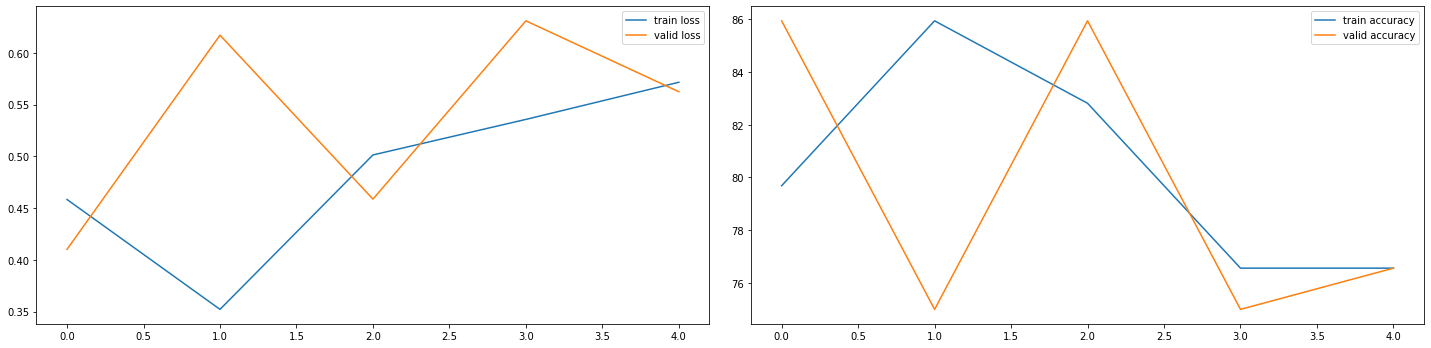

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

In [76]:
epochs = 10
bs = 16
lr = 0.005
wd = 0.0005

def init_weights(layer):  #@save
    """Initialize weights for CNNs."""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_uniform_(layer.weight)

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = LeNet().to(device)
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [77]:
calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

82.31665802001953

**Yeah. Using ADAM gives us much better results**

## Visualizing Kernals

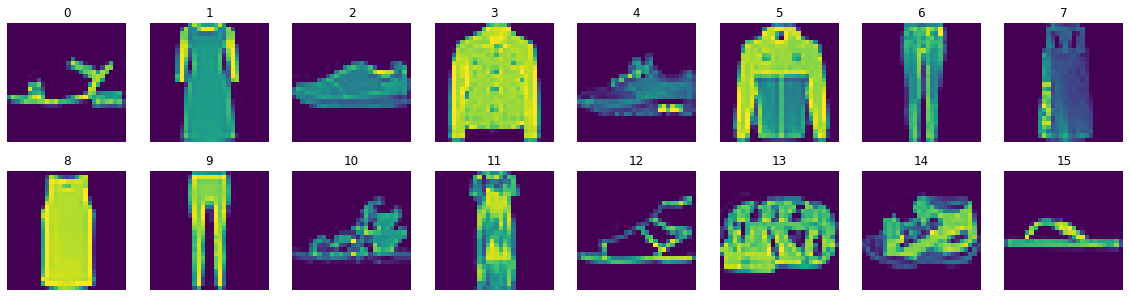

In [78]:
# These are the images we are looking at.
I.wrap(test_images).show(cols=8)

In [79]:
# Now let's see how they will see in first conv layer
_ll = model.net[0:2]
_res = _ll(test_images)
_res.shape

torch.Size([16, 6, 28, 28])

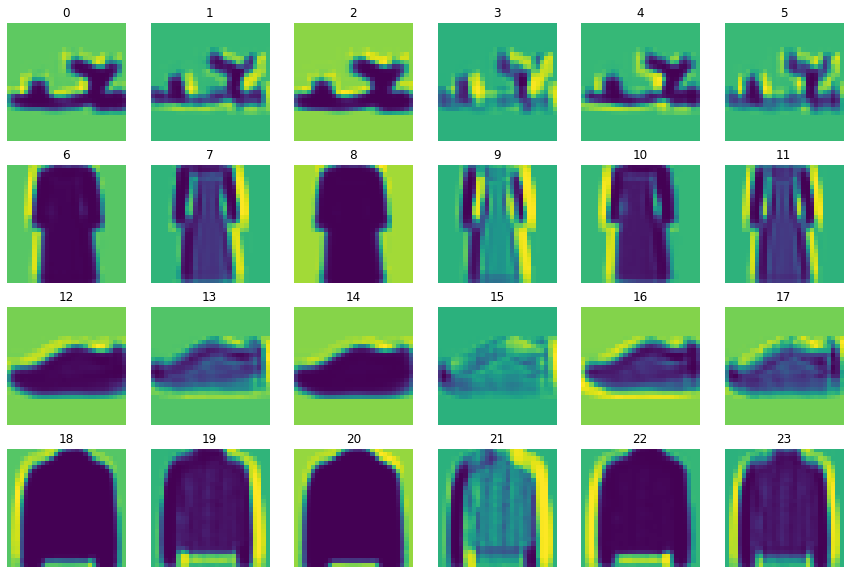

In [80]:
# Let's visualize what these filters will check for
I.wrap(_res[0:4].reshape(-1, 28, 28).unsqueeze(1)).show(cols=6)

In [82]:
# now let's grab a later layer

In [81]:
_ll = model.net[0:5]
_res = _ll(test_images)
_res.shape

torch.Size([16, 16, 10, 10])

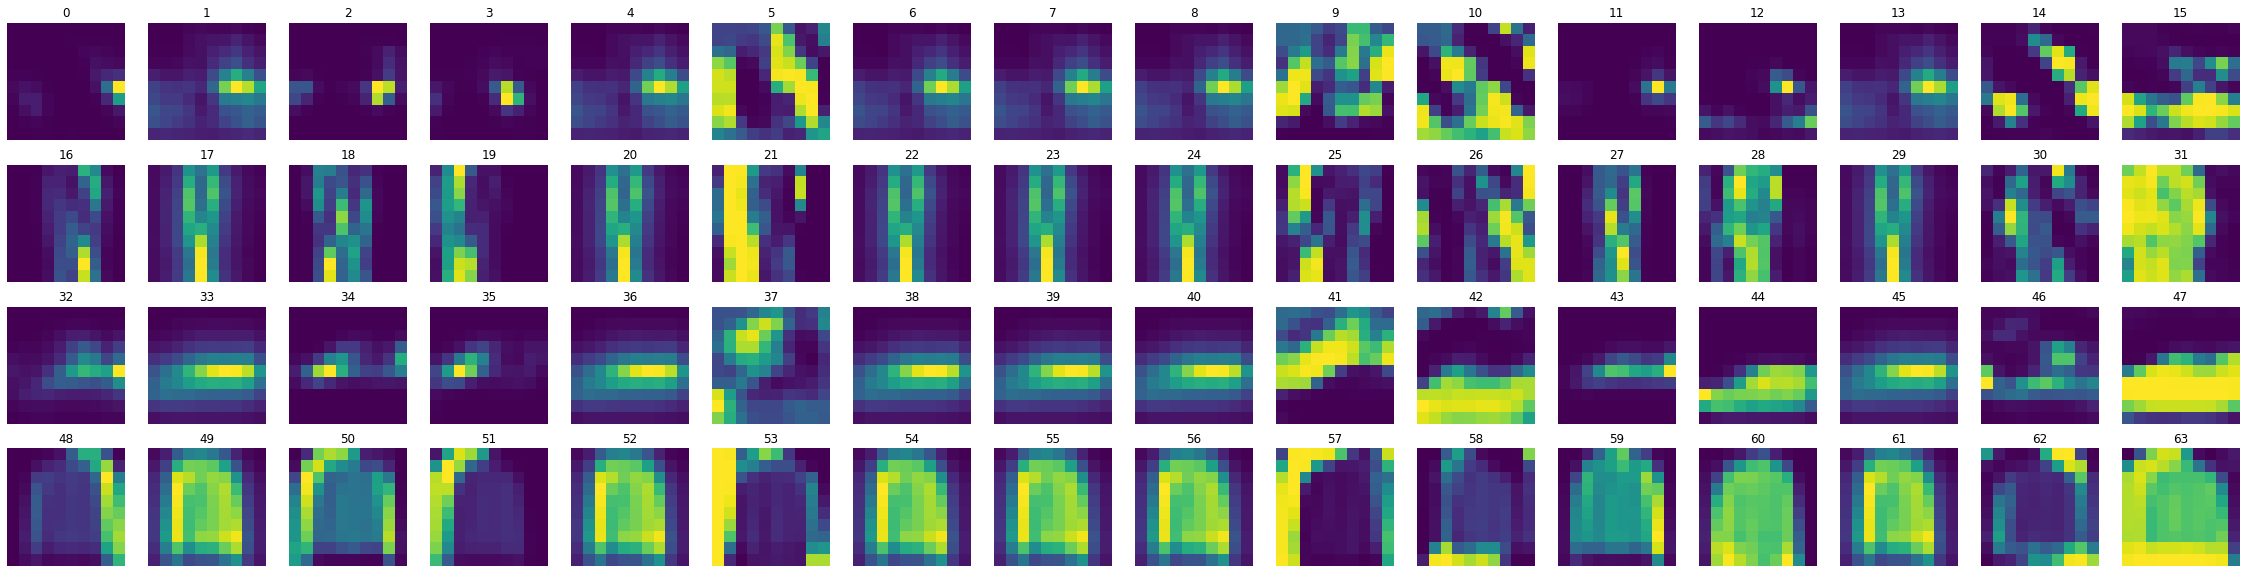

In [84]:
I.wrap(_res[0:4].reshape(-1, 10, 10).unsqueeze(1)).show(cols=16, max_count=1000)

**See. Each filter look at different things.**

## ReLU version of Lenet

In [85]:
class LeNetReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
    def forward(self, inputs):
        return self.net(inputs)
    
_net = LeNetReLU()
_net(sample_batch[0]).shape

torch.Size([16, 10])

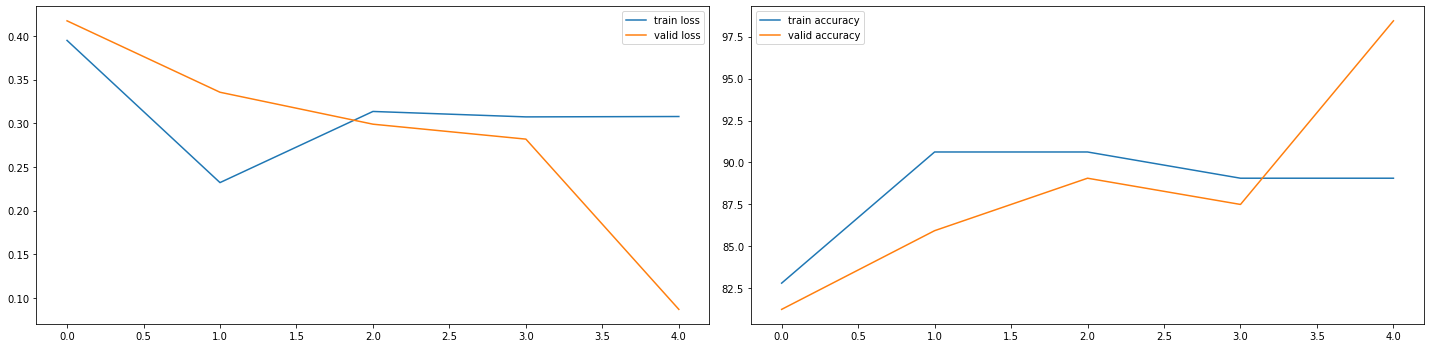

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

In [86]:
epochs = 10
bs = 16
lr = 0.005
wd = 0.0005

def init_weights(layer):  #@save
    """Initialize weights for CNNs."""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_uniform_(layer.weight)

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=bs)
model = LeNetReLU().to(device)
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
train(5)

In [87]:
calc_valid_accuracy()

  0%|          | 0/469 [00:00<?, ?it/s]

88.79264068603516

**Yeah! ReLU version gives us much better results**